In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scienceplots
import pickle
import scipy

from utils import utils
import utils.efinet as efinet
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.metrics import auc, roc_curve, RocCurveDisplay
# import cuml

In [2]:
results_roc = []
results_roc_aug = []

In [3]:
# Plot settings
fpath = "C:/Users/Marek/OneDrive/School/DP/masters-thesis/assets/figures/merged"
# plt.rcParams["font.family"] = ["Latin Modern Roman"]
plt.rcParams["figure.figsize"] = (5, 5)
plt.style.use("science")
# plt.rcParams["savefig.dpi"] = 300
plt.rcParams["font.size"] = 14

mark = "5s"

In [4]:
# Load labels
with open(f"../data/Merged/CLAS_merged_{mark}.pkl", "rb") as f:
    clas_labels = pickle.load(f)
clas_labels = clas_labels["label"]
clas_labels[clas_labels == 1] = 10
clas_labels[clas_labels == 3] = 1
clas_labels[clas_labels == 6] = 1
clas_labels[clas_labels == 8] = 1
idx = clas_labels.isin([0, 1])
clas_labels = clas_labels[idx]

# Load and concat data
with open(f"../data/GADF_Data/GADF_CLAS_merged_{mark}.pkl", "rb") as f:
    clas_gadf = pickle.load(f)

clas_gcn = scipy.io.loadmat(f"../data/GCN_Data/GCN_CLAS_Standard_{mark}.mat")
clas_gcn = np.transpose(clas_gcn["cause5s"], (0, 2, 3, 1))

L = len(clas_gcn)

clas_result = []
for i in range(L):
    clas_result.append(clas_gcn[i] + clas_gadf[i])

clas_data = np.array(clas_result)[idx]

# Load labels
with open(f"../data/Merged/WESAD_merged_{mark}.pkl", "rb") as f:
    wesad_labels = pickle.load(f)
wesad_labels = wesad_labels["model_label"]

# Load and concat data
with open(f"../data/GADF_Data/GADF_WESAD_merged_{mark}.pkl", "rb") as f:
    wesad_gadf = pickle.load(f)

wesad_gcn = scipy.io.loadmat(f"../data/GCN_Data/GCN_WESAD_Standard_{mark}.mat")
wesad_gcn = np.transpose(wesad_gcn["cause5s"], (0, 2, 3, 1))

L = len(wesad_gcn)

wesad_result = []
for i in range(L):
    wesad_result.append(wesad_gcn[i] + wesad_gadf[i])

wesad_data = np.array(wesad_result)

data = np.concatenate((clas_data, wesad_data), axis=0)
labels = np.concatenate((clas_labels, wesad_labels), axis=0)

# Split data into train and test
X, y = data, labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

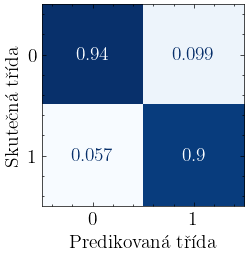

In [5]:
_, eval_model = efinet.build_graph([32, 32, 3], 2, verbose=False)
eval_model.load_weights(f"../results/models/Merged_{mark}.h5")

# Predict the values from the validation dataset
Y_pred = eval_model.predict(X_test)

Y_true = np.argmax(y_test, axis=1)
fpr, tpr, thresholds = roc_curve(Y_true, Y_pred[0][:, 1])
roc_auc = auc(fpr, tpr)
results_roc.append([fpr, tpr, roc_auc])
# utils.print_stats(y_test, Y_pred)
utils.plot_confusion_matrix(y_test, Y_pred, normalize="pred")
plt.savefig(f"{fpath}/merged_{mark}.pdf", format="pdf", bbox_inches="tight")

In [39]:
with open(f"../data/augmented_cuml/WESAD_{mark}_AUG.pkl", "rb") as f:
    data = pickle.load(f)
    X_res1, y_res1 = data["X"], data["y"]

with open(f"../data/augmented_cuml/CLAS_{mark}_AUG.pkl", "rb") as f:
    data = pickle.load(f)
    X_res2, y_res2 = data["X"], data["y"]

X_res = np.concatenate((X_res1, X_res2), axis=0)
y_res = np.concatenate((y_res1, y_res2), axis=0)

X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size=0.20, random_state=42)

y_train_res = to_categorical(y_train_res, num_classes=2)
y_test_res = to_categorical(y_test_res, num_classes=2)

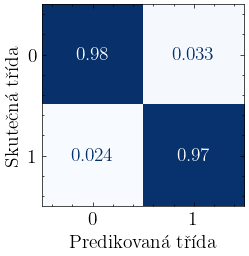

In [40]:
_, eval_model_aug = efinet.build_graph([32, 32, 3], 2)
eval_model_aug.load_weights(f"../results/models/Merged_{mark}_AUG.h5")

# Predict the values from the validation dataset
Y_pred_aug = eval_model_aug.predict(X_test_res)

Y_true_aug = np.argmax(y_test_res, axis=1)
fpr_aug, tpr_aug, thresholds_aug = roc_curve(Y_true_aug, Y_pred_aug[0][:, 1])
roc_auc_aug = auc(fpr_aug, tpr_aug)
results_roc_aug.append([fpr_aug, tpr_aug, roc_auc_aug])
# utils.print_stats(y_test_res, Y_pred_aug)
utils.plot_confusion_matrix(y_test_res, Y_pred_aug)
plt.savefig(f"{fpath}/merged_{mark}_aug.pdf", format="pdf", bbox_inches="tight")

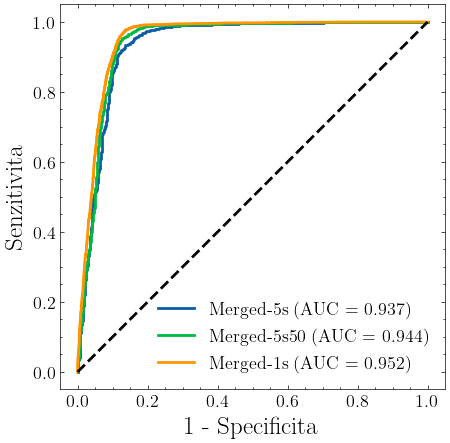

In [41]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["font.size"] = 13

plt.figure()
plt.plot(results_roc[0][0], results_roc[0][1], label=f"Merged-5s (AUC = {np.round(results_roc[0][2], 3)})", linewidth=2)
plt.plot(results_roc[1][0], results_roc[1][1], label=f"Merged-5s50 (AUC = {np.round(results_roc[1][2], 3)})", linewidth=2)
plt.plot(results_roc[2][0], results_roc[2][1], label=f"Merged-1s (AUC = {np.round(results_roc[2][2], 3)})", linewidth=2)
plt.legend()
plt.plot([0, 1], [0, 1], "k--", linewidth=2)
plt.axis("square")
plt.ylabel("Senzitivita", fontsize=18)
plt.xlabel("1 - Specificita", fontsize=18)
plt.savefig(f"{fpath}/merged_roc.pdf", format="pdf", bbox_inches="tight")

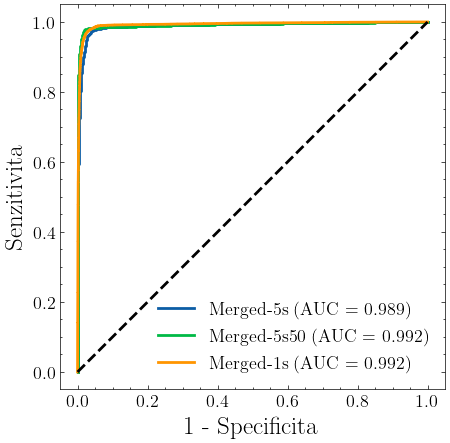

In [42]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["font.size"] = 13

plt.figure()
plt.plot(results_roc_aug[0][0], results_roc_aug[0][1], label=f"Merged-5s (AUC = {np.round(results_roc_aug[0][2], 3)})", linewidth=2)
plt.plot(results_roc_aug[1][0], results_roc_aug[1][1], label=f"Merged-5s50 (AUC = {np.round(results_roc_aug[1][2], 3)})", linewidth=2)
plt.plot(results_roc_aug[2][0], results_roc_aug[2][1], label=f"Merged-1s (AUC = {np.round(results_roc_aug[2][2], 3)})", linewidth=2)
plt.legend(frameon=False)
plt.plot([0, 1], [0, 1], "k--", linewidth=2)
plt.axis("square")
plt.ylabel("Senzitivita", fontsize=18)
plt.xlabel("1 - Specificita", fontsize=18)
plt.savefig(f"{fpath}/merged_roc_aug.pdf", format="pdf", bbox_inches="tight")